# Filtering spiking data

In this notebook we simulate the effect of applying MLSpike to the traces generated by our spike trains. In order to do so, we follow Huang et al., eLife 2021. Here, the autors report the probabilities of detecting an action potential, given the amount of events in a bin of 250ms. 

In order to use this notebook, one first needs to generate a simulated HDF5 file. For more instructions on how to do so, please refer to the `spiking_neuron_model` notebook.

In [1]:
# The autoreload extension allows you to tweak the code in the imported modules
# and rerun cells to reflect the changes.
%load_ext autoreload
%autoreload 2
# this allows us to output the dictionary structure
#%load_ext ipy_dict_hierarchy
# matplotlib settings to look decent in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
# the helpers are in the `/ana/` folder.
sys.path.append("./../")
from ana import ana_helper as ah
from ana import plot_helper as ph
from ana import paper_plots as ppl

#Libraries to generate results from the notebook itself.
import numpy as np
import pandas as pd
from benedict import benedict
import matplotlib.pyplot as plt

In [2]:
# lets load and take a look at the file we have created
h5f = ah.prepare_file("./../dat/test.hdf5")

#We will need a HDF file for the plot_raster.
#Since h5f.copy() does not yield deep copy a solution is to load twice
#and then substitute spiketrain by the filtered one.
h5f_new = ah.prepare_file("./../dat/test.hdf5")

h5f

{'h5': {'filename': './../dat/test.hdf5', 'dsetname': '/', 'file': <HDF5 file "test.hdf5" (mode None)>}, 'data': {'connectivity_matrix_sparse': <HDF5 dataset "connectivity_matrix_sparse": shape (3463, 2), type "<i8">, 'connectivity_segments': <HDF5 dataset "connectivity_segments": shape (3463,), type "<i8">, 'neuron_axon_end_to_end_distance': <HDF5 dataset "neuron_axon_end_to_end_distance": shape (160,), type "<f8">, 'neuron_axon_length': <HDF5 dataset "neuron_axon_length": shape (160,), type "<f8">, 'neuron_axon_segments_x': <HDF5 dataset "neuron_axon_segments_x": shape (160, 232), type "<f8">, 'neuron_axon_segments_y': <HDF5 dataset "neuron_axon_segments_y": shape (160, 232), type "<f8">, 'neuron_bridge_ids': <HDF5 dataset "neuron_bridge_ids": shape (40,), type "<i8">, 'neuron_excitatory_ids': <HDF5 dataset "neuron_excitatory_ids": shape (128,), type "<i8">, 'neuron_g': <HDF5 dataset "neuron_g": shape (160,), type "<f8">, 'neuron_inhibitory_ids': <HDF5 dataset "neuron_inhibitory_ids"

The values below are the measured probabilities obtained from Figure 7 of Huang et al. These where obtained just by analysing the figure with dedicated software. The cases correspond to the MLSpike bars, and different experimental conditions. Which one is used for filtering is indicated later as an argument

In [3]:
#Values of probabilities from the ALife paper have been scrapped and they are hardcoded here
#for the different conditions
prob_values = {}
prob_values["hr_emxs"] = np.array([0.0958, 0.373, 0.575, 0.695, 0.811])
prob_values["hr_tetos"] = np.array([0.194, 0.553, 0.821, 0.7913, 1.0])
prob_values["hr_cuxf"] = np.array([0.096, 0.280, 0.533, 0.568, 0.698])
prob_values["hr_emxf"] = np.array([0.054, 0.396, 0.580, 0.752, 0.916])

prob_values["lr_emxs"] = np.array([0.052, 0.236, 0.423, 0.592, 0.700])
prob_values["lr_tetos"] = np.array([0.106, 0.469, 0.722, 0.939, 1.0])
prob_values["lr_cuxf"] = np.array([0.081, 0.329, 0.649, 0.759, 0.897])
prob_values["lr_emxf"] = np.array([0.049, 0.349, 0.521, 0.624, 0.690])

## Auxiliary functions

These functions are in charge of binning raster plot and performing the filtering from the given spike train

In [4]:
def bin_spikes(spiketimes, bintime=0.25, tf=1200):
    """
    Given an array of spike times, produces a binned timeseries, as a well as an nd-array which contains
    the index of the bin to which each spike time belongs to.
    Parameters
    ==========
    - spiketimes: ndarray
        A NxK array which has the spike times (in seconds) for the all neurons. 
        N is number of neurons, and K the maximum number of spikes. 
        Non-used spaces of the array are coded with NaNs.
    - bintime: float
        Time width of the bin to be used, in seconds. Default is 250ms.
    - tf: float
        Total simulation time, in seconds
    Returns
    =======
    - binned: numpy array
        1-d array that contains the amount of spikes in each bin, as integers.
    - which_bin: ndarray
        An array with shape NxK which instead of having spiketimes contains the index
        of the correspondent bins. 
    """
    
    #Gerate the bins
    bins = np.arange(0, tf, bintime)
    
    #Here we don't care which neuron generated the spike. Just delete nans.
    data = spiketimes.flatten() 
    data = data[~np.isnan(data)]
    
    #Histogram produces the binned activity timeseries. Digitize is a handy function to get in
    #which bin everything was
    return np.histogram(data, bins=bins, density=False)[0], np.digitize(spiketimes, bins=bins)


def prob_2_use(spikecount, prob_detection):
    """
    Selects which probability will be used in each bin, depending on the number of action potential
    in such bins.
    Parameters
    ==========
    - spikecount: ndarray
        A NxK array which has the spike times (in seconds) for the all neurons. 
        See "bin_spikes" docs for more info.
    - prob_detection: ndarray
        1-dim array with 5 elements that contains the probability P(k) of detecting 1 AP if there 
        is k spikes in the bins
    Returns
    =======
    - probs: ndarray
        An array which contains the probability of detection for each time bin.
    """
    
    #By default, probability of detection is 1
    values = np.ones(spikecount.size)
    
    #If there was nothing, nothing to do; 
    #If there is 6+ spikes, assume prob=100%
    mask = (spikecount <= 5) & (spikecount > 0)
    
    #Apply mask
    values[mask] = prob_detection[spikecount[mask] - 1] 
    return values

def spikes_not_detected(binned, prob_values, prob_table="hr_emxs"):
    """
    Returns a new array with the spike count after the filtering is applied.
    Parameters
    ==========
    - binned: ndarray
        Contains the total number of spikes in each bin
    - prob_values: dict
        This dictionary contains the probability P(k) of detecting 1 spike if there 
        is k spikes in the bins for different experimental cases. Which case is selected
        depends on "prob_table" argument. Default is "hr_emxs".
    - p_table: string
        To select one entry from the prob_values dictionary. Possible values are shown in the
        filter_spikes notebook
    Returns
    =======
    - detected_spikes: ndarray
        Contains the detected number of spikes in each bin after the filter is applied
    """  
    #Get the probabilities to use in each bin
    probs = prob_2_use(binned, prob_values[prob_table])
    #Generate values according to a binomial distribution with "n=binned, p=probs" for each bin.
    return np.random.binomial(binned, probs) 


def delete_from_spikeseries(binned, masked, which_bin, spiketimes):
    """
    Given the actual amount of spikes and the result after filtering, erase randomly 
    some action potentials from the spiketimes, without modyfying it.
    Parameters
    ==========
    - binned: ndarray
        Contains the total number of spikes in each bin
    - masked: ndarray
        Contains the detected number of spikes in each bin after the filter is applied
    - which_bin: ndarray
        An array with shape NxK which instead of having spiketimes contains the index
        of the correspondent bins.
    - spiketimes: ndarray
        A NxK array which has the spike times (in seconds) for the all neurons. 
        See "bin_spikes" docs for more info.
    Returns
    =======
    - new_spiketimes: ndarray
        Same as spiketimes, but with some randomly deleted spikes to match the masked array. 
        These are marked with a "-1" value
    """  
    
    #Initialize the arrays
    corrected = np.zeros(binned.size)
    n_neurons, n_times = spiketimes.shape
    new_spikes = spiketimes.copy()
    
    #Loop on times and after that in neurons, to delete spikes "vertically" in the raster
    for j in range(n_times):
        for i in range(n_neurons):
            #In which bin is this spiketime?
            index = which_bin[i,j] - 1 
            
            #Nans are coded as 4800, so everything that is 4799 is not valid
            if index < binned.size-1:
                #binned- masked = number of deleted spikes. So keep deleting
                #until these two are equal
                if masked[index] + corrected[index] < binned[index]:
                    corrected[index] += 1
                    new_spikes[i, j] = -1
    return new_spikes
                

## Filtering

Use the functions defined above to process the data. After that, the spiketrain inside the variable `h5f_new` is substituted by the filtered one, and graphs are produced.

In [5]:
#Shorthand notation
spiketrain = h5f["data"]["spiketimes"]

#Bin the raster plot
binned, which_bin = bin_spikes(spiketrain)

#Apply the filtering and get its spike count
masked = spikes_not_detected(binned, prob_values, prob_table="lr_emxs")

#Use this to delete spikes 
new_spikes = delete_from_spikeseries(binned, masked, which_bin, spiketrain)

#Apply the new spiketrain to the copy of the H5F file
h5f_new["data"]["spiketimes"] = new_spikes

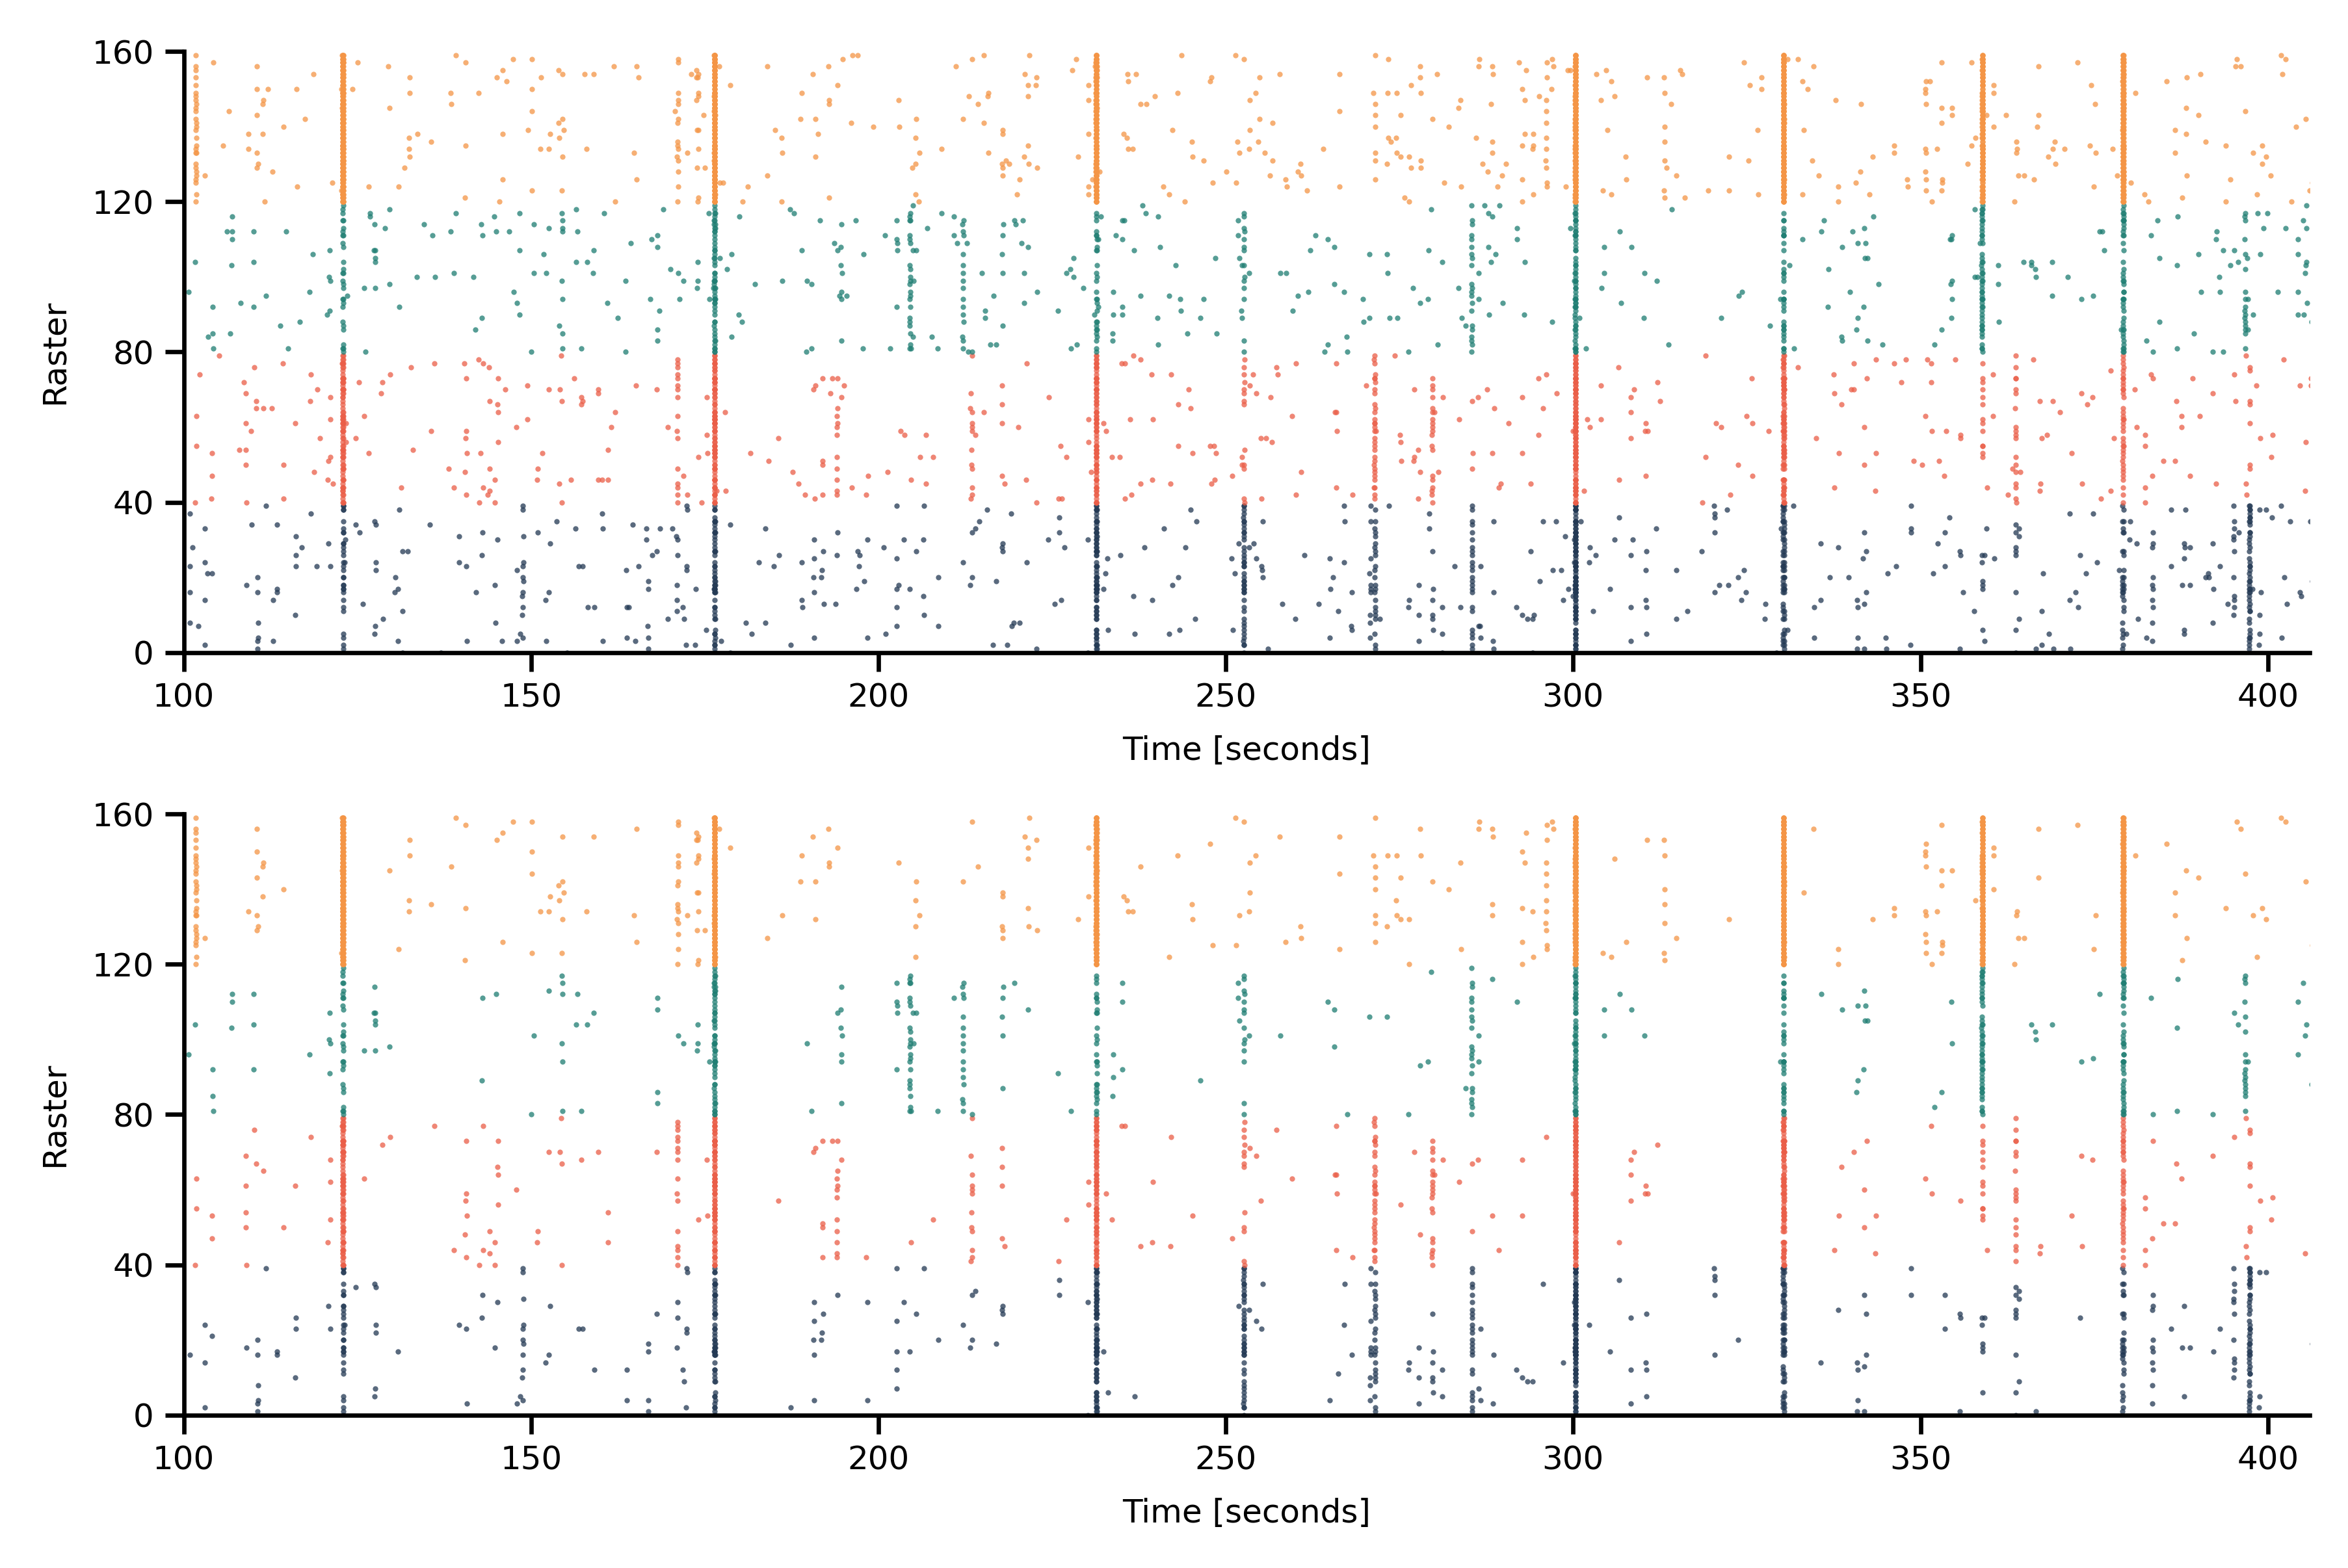

In [6]:
#Produce a beautiful plot
fig, axes = plt.subplots(nrows=2, dpi=300, figsize=(6,4))
ph.plot_raster(h5f,    axes[0])
ph.plot_raster(h5f_new, axes[1])
#fig.savefig("../dat/filtering.pdf")
for ax in axes:
    ax.set_xlim(100, 406)
plt.savefig("rasters.svg")
plt.show()

# Effect of filtering on burst observables

Now we do check the effect of the filtering in some of the system observables. To do so, we first run the function to find rates, which are subsequently used to find bursts and then IBIs. These are plotted for both cases.

In [19]:
#Find rates, modifying the h5f files in-place
ah.find_rates(h5f)
ah.find_rates(h5f_new)

#Use rates to grab bursting events
threshold, min_separation = 10, 0.1
ah.find_system_bursts_from_global_rate(h5f, threshold, min_separation)
ah.find_system_bursts_from_global_rate(h5f_new, threshold, min_separation)

#Use the bursts to find the IBIS
ah.find_ibis(h5f)
ah.find_ibis(h5f_new)

#Although we can use the rates from find_rates, the exact smoothing should give a better
#representation. Let's employ it instead.
rate_old = ah.population_rate_exact_smoothing(h5f["data"]["spiketimes"], 10, 3)
rate_new = ah.population_rate_exact_smoothing(h5f_new["data"]["spiketimes"], 10, 3)
rate_new[0] = 0 #Fix small problem in rate computing

#Convert results into DataFrame, as expected by the plot violins function
df_rate = pd.DataFrame()
nrows = len(rate_old)
#A column for the values
df_rate["Rate"] = np.concatenate([rate_old, rate_new])
#Labels that separate the old from the filtered 
df_rate["Filter"] = ["Before" for k in range(nrows)] + ["After" for k in range(nrows)]

#Repeat for a new DF for bursts. 
df_burst = pd.DataFrame()
#Compute the sequence length to see number of modules participating in a burst
seq_len_old = [len(seq) for seq in h5f["ana.bursts.system_level.module_sequences"]]
seq_len_new = [len(seq) for seq in h5f_new["ana.bursts.system_level.module_sequences"]]
df_burst["Sequence Length"] = np.concatenate([seq_len_old, seq_len_new])
df_burst["Filter"] = ["Before" for k in range(len(seq_len_old))] + ["After" for k in range(len(seq_len_new))]

#Repeat for IBIs
df_ibis = pd.DataFrame()
ibis_old = h5f["ana.ibi.system_level.any_module"]
ibis_new = h5f_new["ana.ibi.system_level.any_module"]
df_ibis["IBIs"] = np.concatenate([ibis_old, ibis_new])
df_ibis["Filter"] = ["Before" for k in range(len(ibis_old))] + ["After" for k in range(len(ibis_new))]

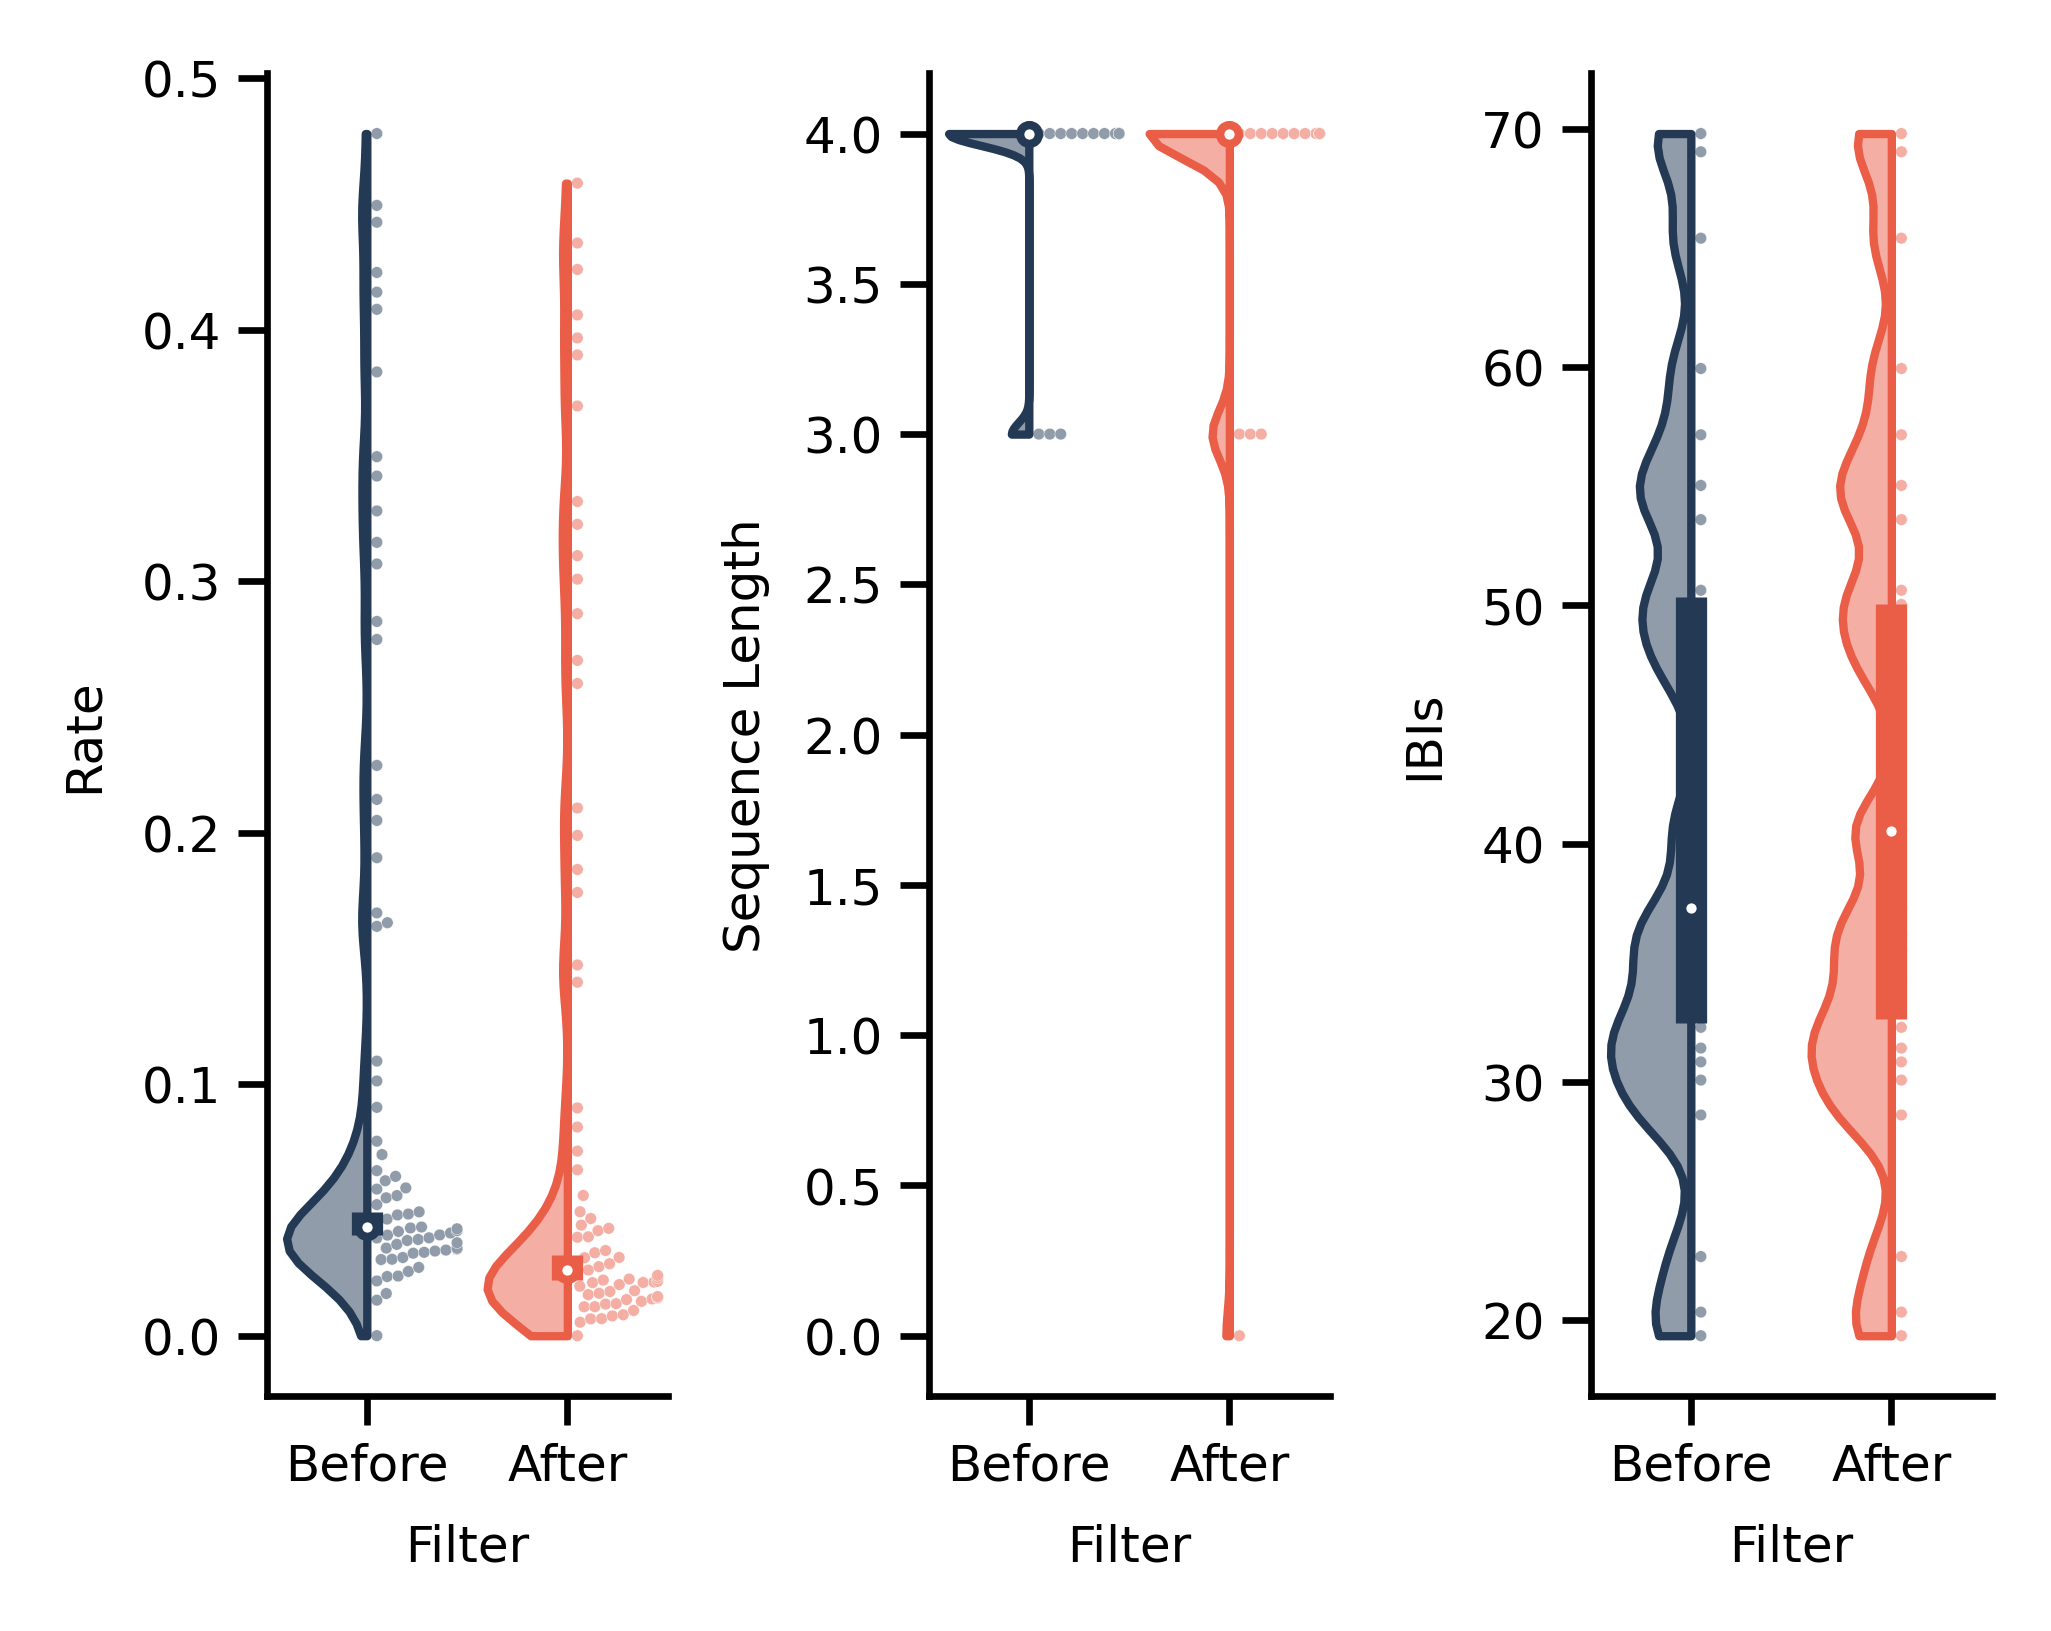

In [21]:
#Plot a small figure
fig, axes = plt.subplots(ncols=3)
ppl.custom_violins(df_rate, category="Filter", observable="Rate", ax=axes[0])
ppl.custom_violins(df_burst, category="Filter", observable="Sequence Length", ax=axes[1])
ppl.custom_violins(df_ibis, category="Filter", observable="IBIs", ax=axes[2])
plt.tight_layout()
plt.savefig("effect_of_filter.svg")
plt.show()

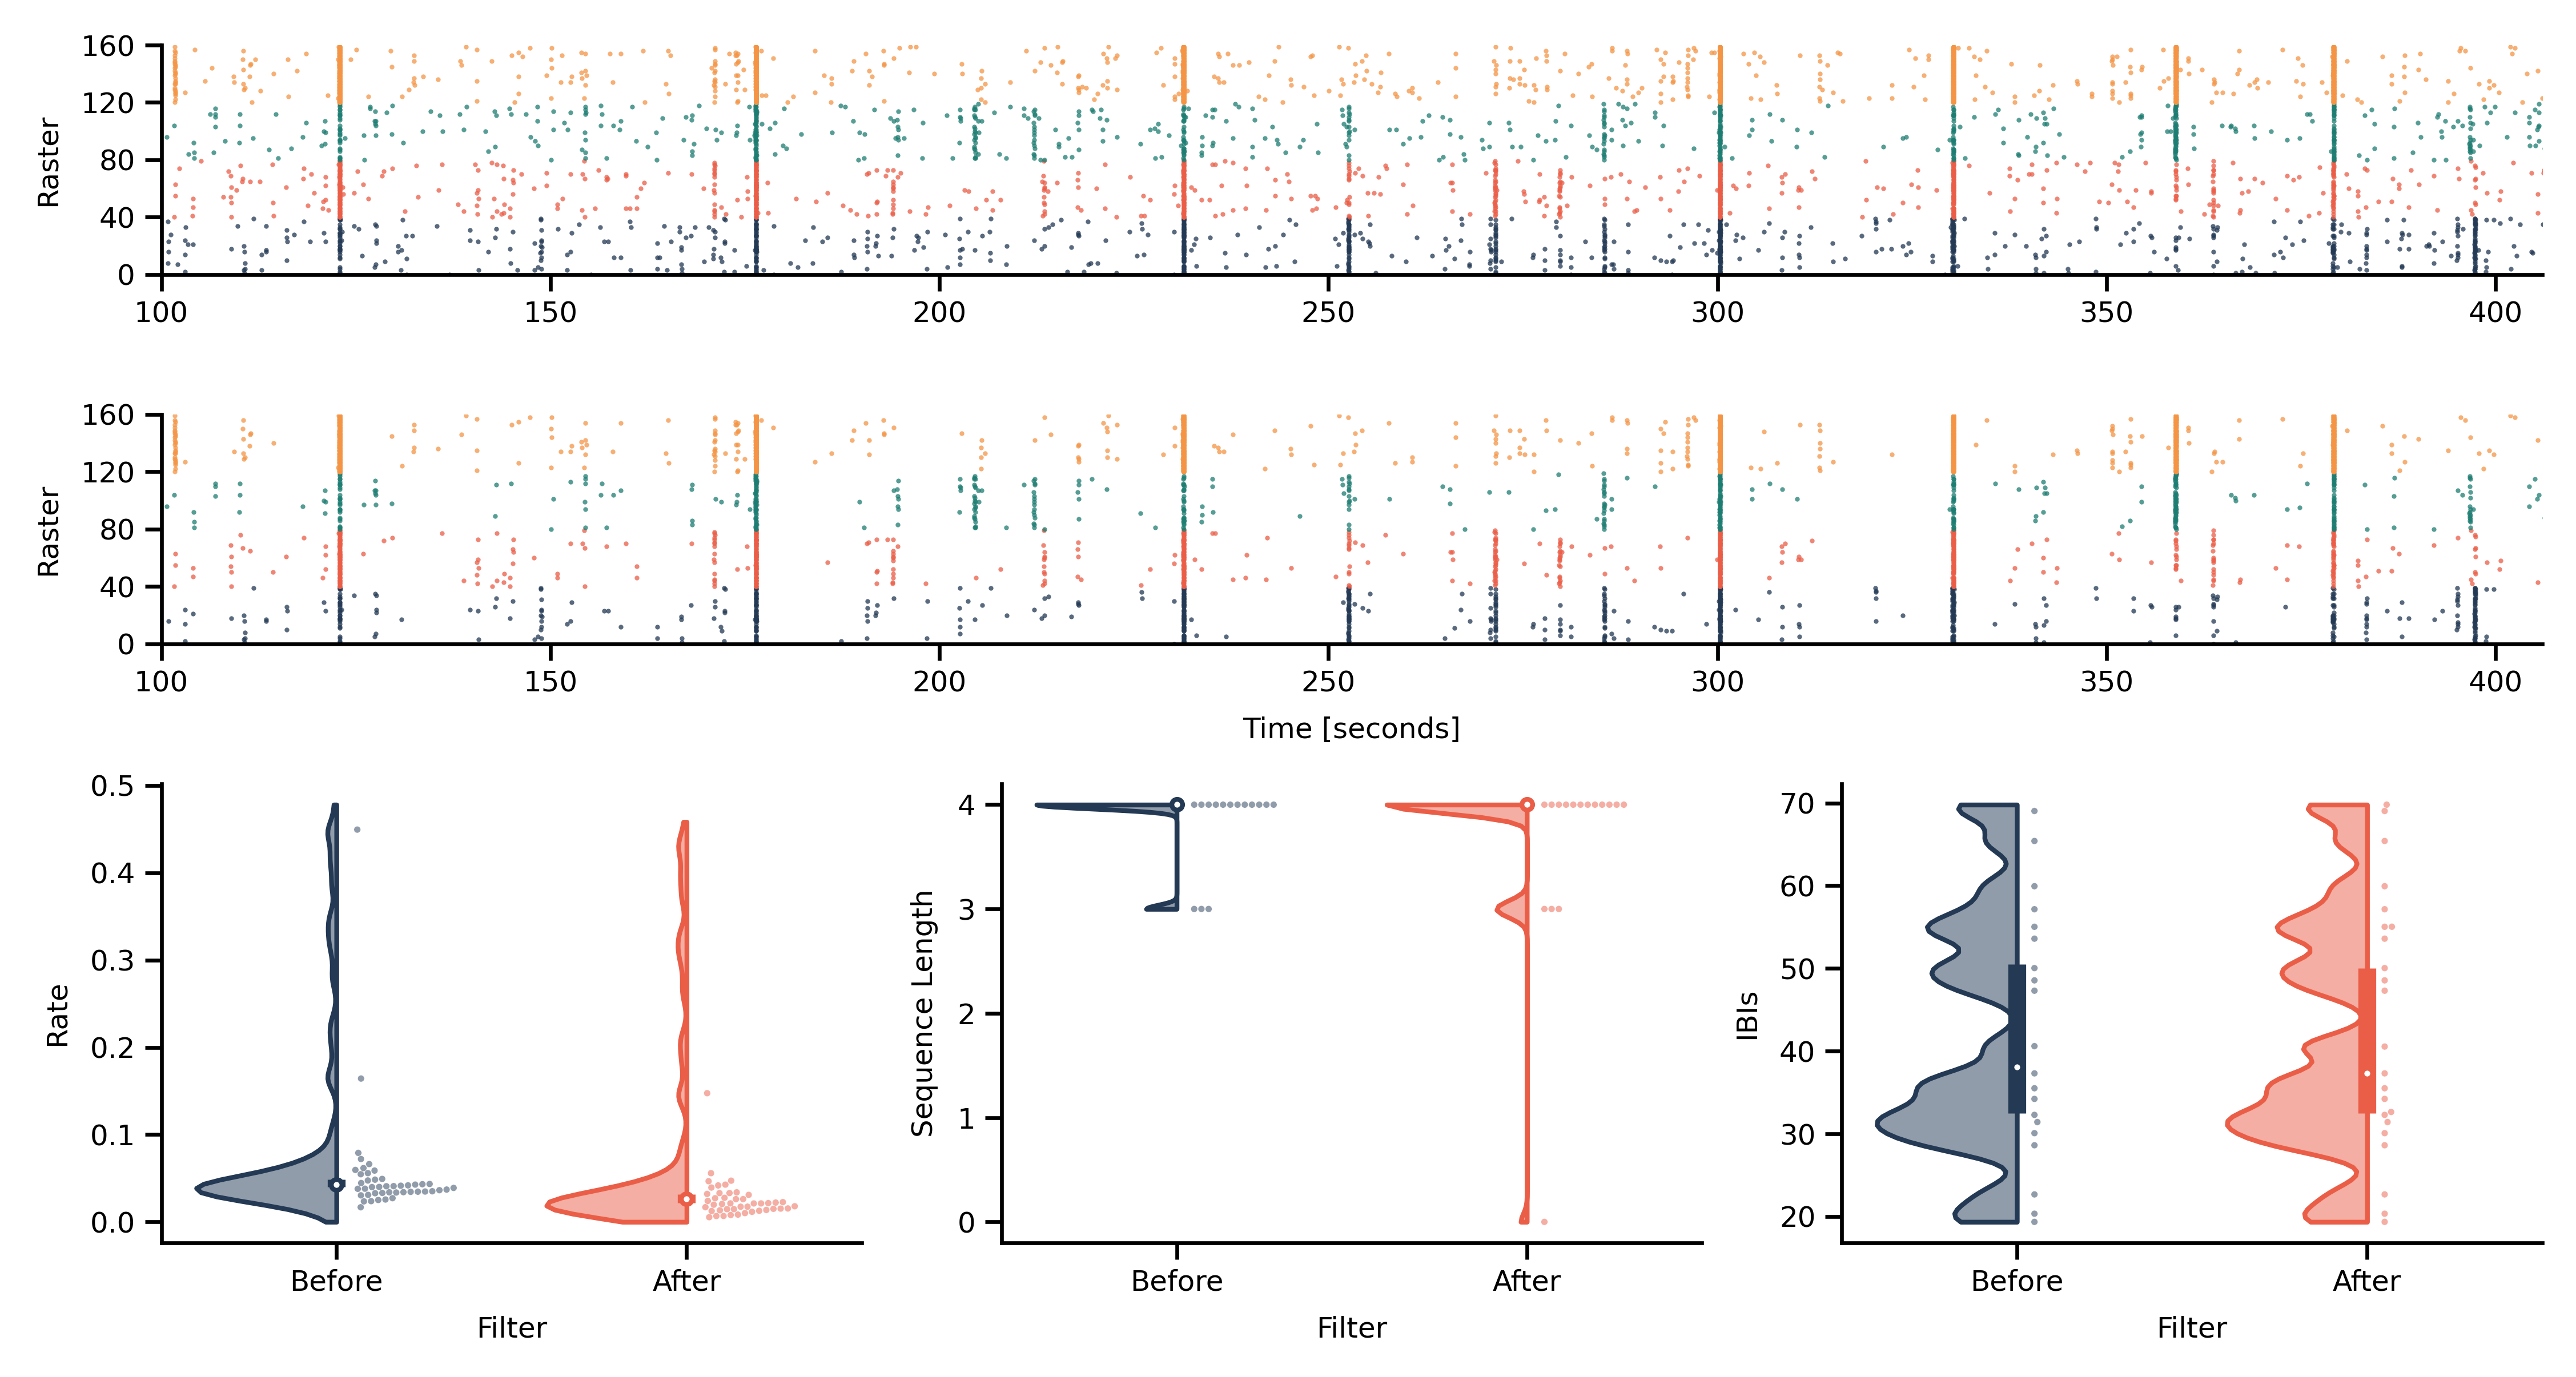

In [20]:
#Plot all together!!

#Paper
fig, axes = plt.subplot_mosaic(
"""
AAA
BBB
CDE
""", 
figsize=(7.5, 4), height_ratios=[0.5, 0.5, 1]
)


ph.plot_raster(h5f,    axes["A"])
axes["A"].set_xlabel("")
ph.plot_raster(h5f_new, axes["B"])
#fig.savefig("../dat/filtering.pdf")
for lab in "AB":
    axes[lab].set_xlim(100, 406)


ppl.custom_violins(df_rate, category="Filter", observable="Rate", ax=axes["C"])
ppl.custom_violins(df_burst, category="Filter", observable="Sequence Length", ax=axes["D"])
ppl.custom_violins(df_ibis, category="Filter", observable="IBIs", ax=axes["E"])
plt.tight_layout()
plt.savefig("effect_filter.pdf")
plt.show()